In [1]:
from alab_experiment_helper import Experiment, sample, tasks
from alab_experiment_helper.sample import Sample

In [2]:
import networkx as nx

In [3]:
from bson import ObjectId
import numpy as np

def generate_sample(exp):
    s = exp.add_sample(name=ObjectId())
    powders_a = ["MAI", "FAI"]
    powders_b = ["PbI2", "PbBr2", "PbCl2"]

    powder_dispenses = {
        np.random.choice(powders_a): np.random.random()*10,
        np.random.choice(powders_b): np.random.random()*10,
    }
    tasks.dispensing(
        s,
        powder_dispenses=powder_dispenses,
    )
    tasks.simple_heating_with_atmosphere(
        s,
        heating_temperature_celsius=np.random.choice([800,1200]),
        heating_time_minutes = np.random.choice([480, 1200]),
        atmosphere = np.random.choice(["N2", "Ar"]),
    )
    tasks.recover_powder(s)
    tasks.xrd(s)
    return s


In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_task_graph(graph, pos_function = None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    color_key = {}
    node_colors = []
    for node_id, node in graph.nodes(data=True):
        if node["type"] not in color_key:
            color_key[node["type"]] = plt.cm.tab10(len(color_key))
        node_colors.append(color_key[node["type"]])

    if pos_function is None:
        pos = nx.spring_layout(graph)
    else:
        pos = pos_function(graph)
    nx.draw(
        graph, 
        pos=pos,
        with_labels=False, 
        labels={n: nd["type"] for n, nd in g.nodes(data=True)},
        node_color = node_colors,
        node_size=50,
        ax=ax
        )

    legend_elements = [
        Line2D([0], [0], marker="o", color=c, label=l, linestyle="")
        for l,c in color_key.items()
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor = (1.05, 1), loc = "upper left")

In [5]:
def count_nodes(graph):
    node_counts = {}    
    for node_id, node in graph.nodes(data=True):
        if node["type"] not in node_counts:
            node_counts[node["type"]] = 0
        node_counts[node["type"]] += 1
    return node_counts

-----
# Batch nodes all at once

In [158]:
from typing import Callable
def merge_nodes(graph:nx.DiGraph, node_type:str, parent_graph:nx.DiGraph = None, merge_allowed_fn:Callable = None) -> nx.DiGraph:
    if parent_graph is None:
        parent_graph = graph
    node_ids = list(graph.nodes)
    removed_nodes = []
    for reference_node_id in node_ids:
        if reference_node_id in removed_nodes:
            continue
        # reference_node_id = node_ids[reference_index]
        try:
            ref = graph.nodes[reference_node_id]
        except:
            break #we merged nodes, so ran out of entries early. This is fine, just end the loop.
        replace = []
        capacity = ref["capacity"]
        ref_samples = ref["samples"]

        for tid, task in graph.nodes(data=True):
            if tid == reference_node_id:
                continue
            if task["type"] != ref["type"]:
                continue
            if task["type"] != node_type:
                continue
            if len(task["samples"]) + len(ref_samples) > capacity:
                continue
            if merge_allowed_fn is not None:
                if not merge_allowed_fn(ref, task):
                    continue

            replace.append(tid)
            ref_samples.extend(task["samples"])

            if len(ref_samples) == capacity:
                break
        
        if len(replace) == 0:
            continue
        for replace_id in replace:
            for prev in parent_graph.predecessors(replace_id):
                parent_graph.add_edge(prev, reference_node_id)
            for next in parent_graph.successors(replace_id):
                parent_graph.add_edge(reference_node_id, next)
            parent_graph.remove_node(replace_id)
            removed_nodes.append(replace_id)
        parent_graph.nodes[reference_node_id]["samples"] = ref_samples
    return graph


In [129]:
exp = Experiment("dummy")
for i in range(10):
    generate_sample(exp)
exp.to_dict(); #generate prev_tasks

In [130]:
g = nx.DiGraph()

for task_id, task in exp._tasks.items():
    g.add_node(task_id, type=task["type"], parameters=task["parameters"], capacity=task["capacity"], samples=task["samples"])
    for prev_task_index in task["prev_tasks"]:
        prev_task_id = list(exp._tasks.keys())[prev_task_index]
        g.add_edge(prev_task_id, task_id)


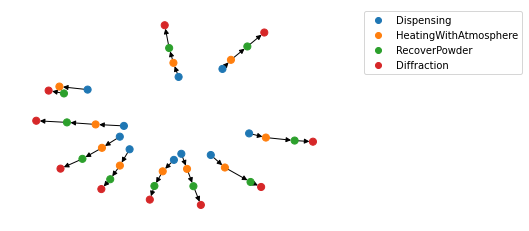

In [131]:
plot_task_graph(g, pos_function=nx.spring_layout)

In [132]:
count_nodes(g)

{'Dispensing': 10,
 'HeatingWithAtmosphere': 10,
 'RecoverPowder': 10,
 'Diffraction': 10}

In [133]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  40 Number of edges:  30


In [134]:
subgraphs = [g.subgraph(c).copy() for c in nx.connected_components(g_)]

In [135]:
node_ids = list(g.nodes)
for reference_index in range(len(node_ids)):
    reference_node_id = node_ids[reference_index]
    ref = g.nodes[reference_node_id]
    replace = []
    capacity = ref["capacity"]
    ref_samples = ref["samples"]

    for tid, task in g.nodes(data=True):
        if tid == reference_node_id:
            continue
        if task["type"] != ref["type"]:
            continue
        if task["type"] != "Dispensing":
            if task["parameters"] != ref["parameters"]:
                continue
        if len(task["samples"]) + len(ref_samples) > capacity:
            continue
        replace.append(tid)
        ref_samples.extend(task["samples"])

        if len(ref_samples) == capacity:
            break
    
    if len(replace) == 0:
        continue
    for replace_id in replace:
        for prev in g.predecessors(replace_id):
            g.add_edge(prev, reference_node_id)
        for next in g.successors(replace_id):
            g.add_edge(reference_node_id, next)
        g.remove_node(replace_id)
        node_ids.remove(replace_id)
    g.nodes[reference_node_id]["samples"] = ref_samples

    

IndexError: list index out of range

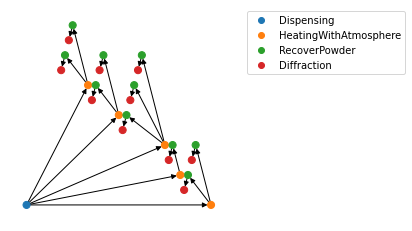

In [136]:
fig, ax = plt.subplots(figsize=(4,4))
plot_task_graph(g, pos_function=nx.planar_layout, ax=ax)

In [137]:
count_nodes(g)

{'Dispensing': 1,
 'HeatingWithAtmosphere': 5,
 'RecoverPowder': 10,
 'Diffraction': 10}

In [138]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  26 Number of edges:  25


----
# Hierarchical Batching
First, bin things into furnace runs

Next, bin things into Labman workflows such that furnace runs are weighed together

In [150]:
def get_subgraphs(graph):
    subgraphs = [graph.subgraph(c) for c in nx.connected_components(graph.to_undirected())]
    return subgraphs

In [151]:
def subgraph_from_node(graph, node_id):
    subgraph_nodes = set([node_id])
    subgraph_nodes.update(nx.descendants(graph, node_id))
    subgraph_nodes.update(nx.ancestors(graph, node_id))
    
    return nx.subgraph(g, subgraph_nodes)

In [152]:
exp = Experiment("dummy")
for i in range(100):
    generate_sample(exp)
exp.to_dict(); #generate prev_tasks

In [153]:
g = nx.DiGraph()

for task_id, task in exp._tasks.items():
    g.add_node(task_id, type=task["type"], parameters=task["parameters"], capacity=task["capacity"], samples=task["samples"])
    for prev_task_index in task["prev_tasks"]:
        prev_task_id = list(exp._tasks.keys())[prev_task_index]
        g.add_edge(prev_task_id, task_id)


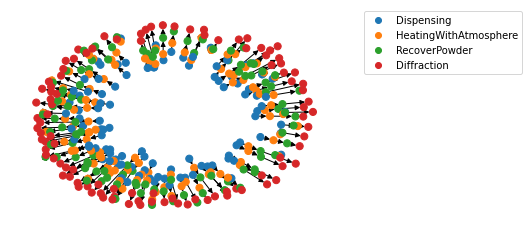

In [154]:
plot_task_graph(g)

In [155]:
count_nodes(g)

{'Dispensing': 100,
 'HeatingWithAtmosphere': 100,
 'RecoverPowder': 100,
 'Diffraction': 100}

In [156]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  400 Number of edges:  300


## Batch

Batch the heating steps

In [165]:
merge_nodes(g, "HeatingWithAtmosphere", merge_allowed_fn = lambda x,y: x["parameters"] == y["parameters"])
for subgraph in get_subgraphs(g):
    merge_nodes(subgraph, "Dispensing", parent_graph = g)
merge_nodes(g, "Dispensing")

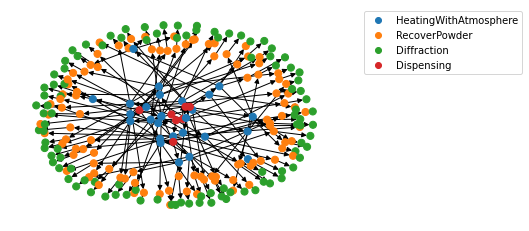

In [166]:
plot_task_graph(g)

In [167]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  234 Number of edges:  227


In [168]:
count_nodes(g)

{'HeatingWithAtmosphere': 27,
 'RecoverPowder': 100,
 'Diffraction': 100,
 'Dispensing': 7}

In [169]:
len(get_subgraphs(g))

7

Batch the Dispensing steps

In [170]:
subgraphs = get_subgraphs(g)

In [201]:
def powder_set_similarity(a:list, b:list):
    a_set = set()
    for p in a:
        a_set.update(p["parameters"]["powder_dispenses"])
    
    b_set = set()
    for p in b:
        b_set.update(p["parameters"]["powder_dispenses"])
        
    return 1-len(a_set.intersection(b_set)) / len(a_set.union(b_set))

In [219]:
from functools import lru_cache

@lru_cache(maxsize=1000)
def get_dispenses_from_node(graph, node_id):
    sg = subgraph_from_node(graph, node_id)
    dispenses = [node for node_id, node in sg.nodes(data=True) if node["type"] == "Dispensing"]
    return dispenses

In [240]:
heating_node_ids = [node_id for node_id, node in g.nodes(data=True) if node["type"] in ["Heating", "HeatingWithAtmosphere"]]
dispense_node_ids = [node_id for node_id, node in g.nodes(data=True) if node["type"] == "Dispensing"]

similarity = np.ones((len(heating_node_ids), len(heating_node_ids)))
for i in range(len(heating_node_ids)):
    for j in range(len(heating_node_ids)):
        if i == j:
            continue
        if i < j:
            continue
        dispenses_i = get_dispenses_from_node(g, heating_node_ids[i])
        dispenses_j = get_dispenses_from_node(g, heating_node_ids[j])
        similarity[i,j] = similarity[j,i] = powder_set_similarity(dispenses_i, dispenses_j)

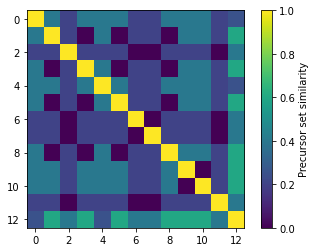

In [242]:
plt.imshow(similarity, vmin=0, vmax=1)
plt.colorbar(label="Precursor set similarity")

In [253]:
powders = {}
for node_id in dispense_node_ids:
    powders[node_id] = set([p for p in g.nodes[node_id]["parameters"]["powder_dispenses"]])
unique_powders = list(set.union(*powders.values()))

powder_in_dispense = []
for powd in powders.values():
    powder_in_dispense.append([p in powd for p in unique_powders])


In [ ]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver.CreateSolver('SCIP')



In [194]:
for reference_node_id in heating_node_ids:
    preferred_pairings = heating_node_ids.copy()
    reference_dispenses = get_dispenses_from_node(g, reference_node_id)
    preferred_pairings.sort(key = lambda x: powder_set_similarity(reference_dispenses, get_dispenses_from_node(g, x)), reverse=True) #most to least similar
    
    for pair_id in preferred_pairings:
        if pair_id == reference_node_id:
            continue
        
    reference_node_id = node_ids[reference_index]
    ref = g.nodes[reference_node_id]
    if ref["type"] != "Dispensing":
        continue
    replace = []
    capacity = ref["capacity"]
    ref_samples = ref["samples"]

    for tid, task in g.nodes(data=True):
        if task["type"] != "Dispensing":
                continue
        if tid == reference_node_id:
            continue

        if len(task["samples"]) + len(ref_samples) > capacity:
            continue
        replace.append(tid)
        ref_samples.extend(task["samples"])

        if len(ref_samples) == capacity:
            break
    
    if len(replace) == 0:
        continue
    for replace_id in replace:
        for prev in g.predecessors(replace_id):
            g.add_edge(prev, reference_node_id)
        for next in g.successors(replace_id):
            g.add_edge(reference_node_id, next)
        g.remove_node(replace_id)
        node_ids.remove(replace_id)
    g.nodes[reference_node_id]["samples"] = ref_samples

    

IndexError: list index out of range

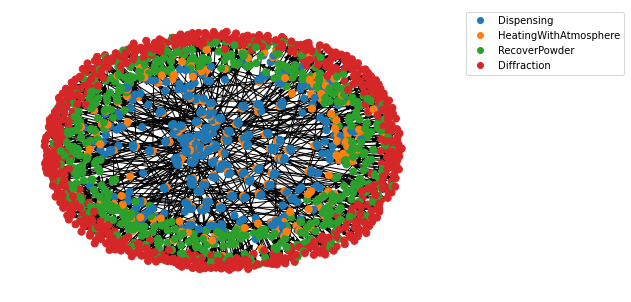

In [ ]:
plot_task_graph(g)

In [ ]:
count_nodes(g)

{'Dispensing': 550,
 'HeatingWithAtmosphere': 230,
 'RecoverPowder': 550,
 'Diffraction': 550}

In [ ]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  1880 Number of edges:  1650
